In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import kagglehub

In [ ]:
path = kagglehub.dataset_download("a2015003713/militaryaircraftdetectiondataset")

print("Path to dataset files:", path)

100%|██████████| 9.78G/9.78G [07:37<00:00, 22.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/a2015003713/militaryaircraftdetectiondataset/versions/86


In [ ]:
!ls sample_data/crop

A10    An72   C130   E2      F16   J10	  Ka52	 Mi28	     Rafale  TB001    UH60    Y20
A400M  AV8B   C17    E7      F18   J20	  KAAN	 Mi8	     RQ4     TB2      US2     YF23
AG600  B1     C2     EF2000  F22   J35	  KC135  Mig29	     SR71    Tornado  V22     Z10
AH64   B2     C390   EMB314  F35   JAS39  KF21	 Mig31	     Su24    Tu160    V280    Z19
An124  B21    C5     F117    F4    JF17   KJ600  Mirage2000  Su25    Tu22M    Vulcan
An22   B52    CH47   F14     H6    JH7	  Mi24	 MQ9	     Su34    Tu95     WZ7
An225  Be200  CL415  F15     Il76  Ka27   Mi26	 P3	     Su57    U2       XB70


In [ ]:
import os

num_skipped = 0

for folder_name in ("F16", "Su24"):
  folder_path = os.path.join("sample_data", "crop", folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    try:
      fobj = open(fpath, "rb")
      is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
    finally:
      fobj.close()

    if not is_jfif:
      num_skipped += 1
      os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [ ]:
image_size = (180, 180)
batch_size = 32
class_names = ['F16', 'Su24']

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "sample_data/crop",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    class_names=class_names
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "sample_data/crop",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    class_names=class_names
)

Found 2261 files belonging to 2 classes.
Using 1809 files for training.
Found 2261 files belonging to 2 classes.
Using 452 files for validation.


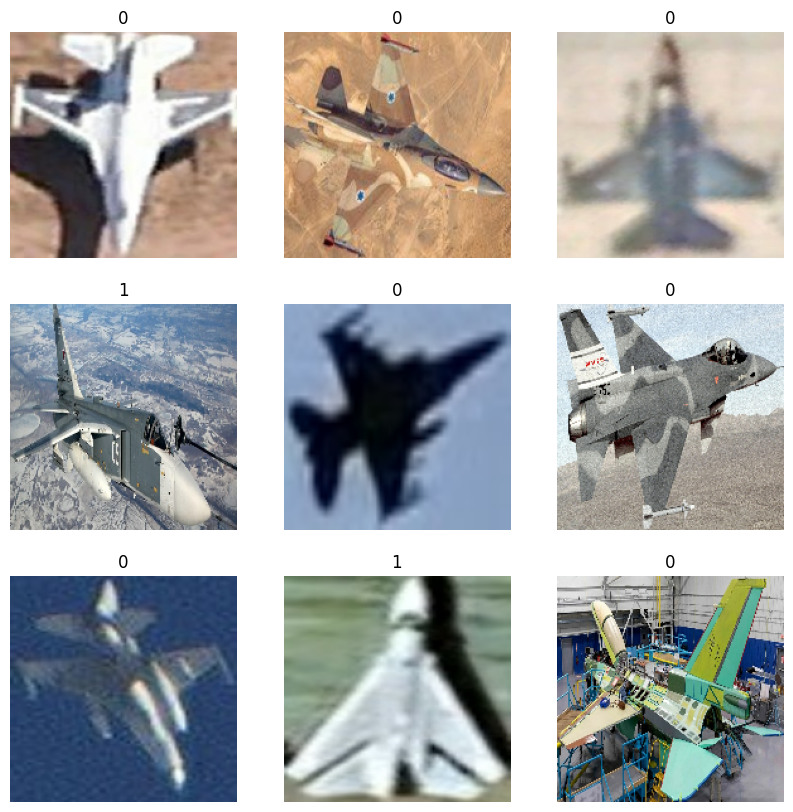

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

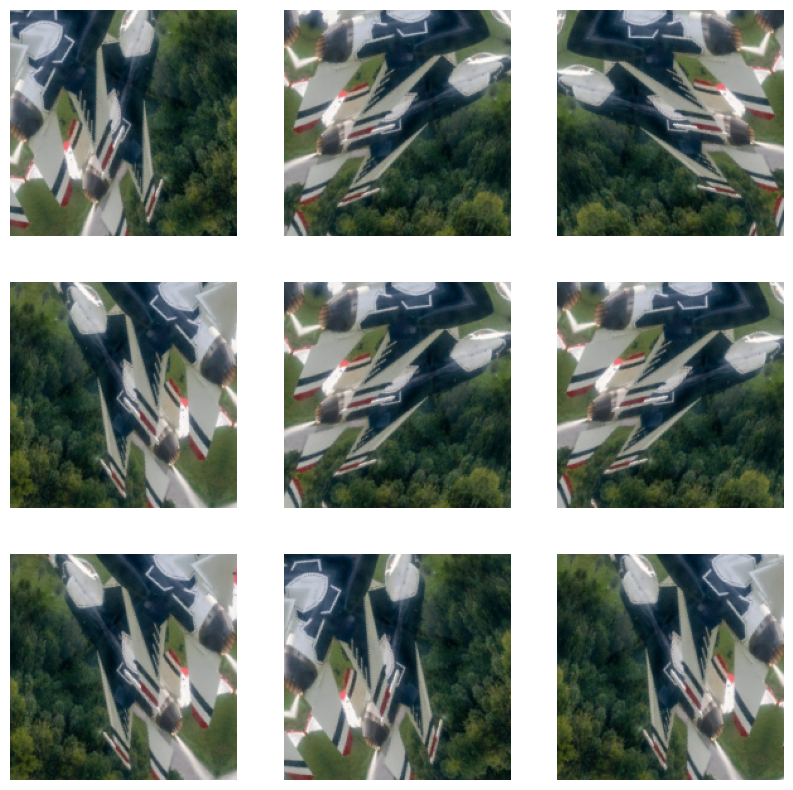

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [ ]:
def make_model(input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)
  x = data_augmentation(inputs)

  x = layers.Rescaling(1.0 / 255)(x)
  x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.Conv2D(64, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  previous_block_activation = x

  for size in [128, 256, 512, 728]:
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(size, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = layers.add([x, residual])
    previous_block_activation = x

  x = layers.SeparableConv2D(1024, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 2:
    activation = "sigmoid"
    units = 1
  else:
    activation = "softmax"
    units = num_classes

  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(units=units, activation=activation)(x)

  return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9521 - loss: 0.1355

57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 269ms/step - accuracy: 0.9522 - loss: 0.1355 - val_accuracy: 0.9137 - val_loss: 0.3103
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9555 - loss: 0.1140

57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - accuracy: 0.9554 - loss: 0.1139 - val_accuracy: 0.8982 - val_loss: 0.5121
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9539 - loss: 0.1175

57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 252ms/step - accuracy: 0.9540 - loss: 0.1173 - val_accuracy: 0.9204 - val_loss: 0.3487
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9780 - loss: 0.0577

57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 250ms/step - accuracy: 0.9780 - loss: 0.0578 - val_accuracy: 0.9049 - val_loss: 0.4802
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9537 - loss: 0.1147

57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 280ms/step - accuracy: 0.9538 - loss: 0.1147 - val_accuracy: 0.8982 - val_loss: 0.4582
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9692 - loss: 0.0815

57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 259ms/step - accuracy: 0.9692 - loss: 0.0815 - val_accuracy: 0.8827 - val_loss: 0.4323
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9775 - loss: 0.0786

57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 258ms/step - accuracy: 0.9775 - loss: 0.0786 - val_accuracy: 0.8872 - val_loss: 0.4215
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9635 - loss: 0.0876

57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 252ms/step - accuracy: 0.9635 - loss: 0.0878 - val_accuracy: 0.8938 - val_loss: 0.3847
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9644 - loss: 0.0942

57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 252ms/step - accuracy: 0.9644 - loss: 0.0942 - val_accuracy: 0.9336 - val_loss: 0.3176
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9679 - loss: 0.0936

57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 253ms/step - accuracy: 0.9679 - loss: 0.0935 - val_accuracy: 0.9204 - val_loss: 0.2707
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9794 - loss: 0.0662

57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 255ms/step - accuracy: 0.9794 - loss: 0.0661 - val_accuracy: 0.9181 - val_loss: 0.4008
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9796 - loss: 0.0675

57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 281ms/step - accuracy: 0.9796 - loss: 0.0672 - val_accuracy: 0.9071 - val_loss: 0.3962
Epoch 13/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9807 - loss: 0.0584

57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 256ms/step - accuracy: 0.9806 - loss: 0.0584 - val_accuracy: 0.8850 - val_loss: 0.4970
Epoch 14/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9607 - loss: 0.0936

57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 257ms/step - accuracy: 0.9607 - loss: 0.0937 - val_accuracy: 0.9049 - val_loss: 0.3006
Epoch 15/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9677 - loss: 0.0888

57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 258ms/step - accuracy: 0.9676 - loss: 0.0888 - val_accuracy: 0.8938 - val_loss: 0.5656
Epoch 16/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9539 - loss: 0.0996

57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step - accuracy: 0.9540 - loss: 0.0994 - val_accuracy: 0.8938 - val_loss: 0.4269
Epoch 17/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9698 - loss: 0.0758

57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 250ms/step - accuracy: 0.9698 - loss: 0.0758 - val_accuracy: 0.9248 - val_loss: 0.3455
Epoch 18/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9795 - loss: 0.0549

57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 258ms/step - accuracy: 0.9794 - loss: 0.0550 - val_accuracy: 0.9248 - val_loss: 0.2603
Epoch 19/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9745 - loss: 0.0641

57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 254ms/step - accuracy: 0.9744 - loss: 0.0643 - val_accuracy: 0.9425 - val_loss: 0.3066
Epoch 20/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9712 - loss: 0.0849

57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 282ms/step - accuracy: 0.9713 - loss: 0.0847 - val_accuracy: 0.9292 - val_loss: 0.3572
Epoch 21/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9770 - loss: 0.0575

57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 257ms/step - accuracy: 0.9770 - loss: 0.0575 - val_accuracy: 0.8938 - val_loss: 0.5614
Epoch 22/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9795 - loss: 0.0568

57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 252ms/step - accuracy: 0.9794 - loss: 0.0568 - val_accuracy: 0.9314 - val_loss: 0.3770
Epoch 23/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9761 - loss: 0.0703

57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 252ms/step - accuracy: 0.9761 - loss: 0.0703 - val_accuracy: 0.9027 - val_loss: 0.3372
Epoch 24/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9715 - loss: 0.0670

57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 256ms/step - accuracy: 0.9715 - loss: 0.0670 - val_accuracy: 0.9137 - val_loss: 0.4454
Epoch 25/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9764 - loss: 0.0549

57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 252ms/step - accuracy: 0.9764 - loss: 0.0550 - val_accuracy: 0.9248 - val_loss: 0.3767
Epoch 26/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9706 - loss: 0.0777

57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 259ms/step - accuracy: 0.9708 - loss: 0.0776 - val_accuracy: 0.9358 - val_loss: 0.2773
Epoch 27/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9750 - loss: 0.0742

57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 259ms/step - accuracy: 0.9750 - loss: 0.0743 - val_accuracy: 0.9358 - val_loss: 0.3075
Epoch 28/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9810 - loss: 0.0569

57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 256ms/step - accuracy: 0.9809 - loss: 0.0569 - val_accuracy: 0.9358 - val_loss: 0.2608
Epoch 29/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9739 - loss: 0.0735

57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 261ms/step - accuracy: 0.9739 - loss: 0.0737 - val_accuracy: 0.8960 - val_loss: 0.5904
Epoch 30/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9659 - loss: 0.0811

57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 252ms/step - accuracy: 0.9660 - loss: 0.0810 - val_accuracy: 0.8872 - val_loss: 0.5367
Epoch 31/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9826 - loss: 0.0532

57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 257ms/step - accuracy: 0.9827 - loss: 0.0530 - val_accuracy: 0.9159 - val_loss: 0.4303
Epoch 32/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9914 - loss: 0.0240

57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 282ms/step - accuracy: 0.9914 - loss: 0.0241 - val_accuracy: 0.9204 - val_loss: 0.4914
Epoch 33/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9885 - loss: 0.0333

57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 251ms/step - accuracy: 0.9885 - loss: 0.0334 - val_accuracy: 0.9336 - val_loss: 0.3508
Epoch 34/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9858 - loss: 0.0395

57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 254ms/step - accuracy: 0.9858 - loss: 0.0395 - val_accuracy: 0.9314 - val_loss: 0.4725
Epoch 35/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9798 - loss: 0.0676

57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 281ms/step - accuracy: 0.9799 - loss: 0.0673 - val_accuracy: 0.9358 - val_loss: 0.4154
Epoch 36/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9843 - loss: 0.0450

57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 251ms/step - accuracy: 0.9843 - loss: 0.0451 - val_accuracy: 0.9137 - val_loss: 0.3476
Epoch 37/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9887 - loss: 0.0330

57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 254ms/step - accuracy: 0.9887 - loss: 0.0330 - val_accuracy: 0.9226 - val_loss: 0.3158
Epoch 38/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9738 - loss: 0.0647

57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 264ms/step - accuracy: 0.9738 - loss: 0.0648 - val_accuracy: 0.8938 - val_loss: 0.8279
Epoch 39/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9668 - loss: 0.0810

57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 256ms/step - accuracy: 0.9669 - loss: 0.0809 - val_accuracy: 0.9403 - val_loss: 0.2974
Epoch 40/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9854 - loss: 0.0456

57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 258ms/step - accuracy: 0.9854 - loss: 0.0455 - val_accuracy: 0.9248 - val_loss: 0.3906
Epoch 41/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9866 - loss: 0.0371

57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step - accuracy: 0.9865 - loss: 0.0374 - val_accuracy: 0.9270 - val_loss: 0.4212
Epoch 42/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9865 - loss: 0.0484

57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 254ms/step - accuracy: 0.9865 - loss: 0.0483 - val_accuracy: 0.9314 - val_loss: 0.3804
Epoch 43/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9739 - loss: 0.0650

57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 260ms/step - accuracy: 0.9740 - loss: 0.0648 - val_accuracy: 0.9314 - val_loss: 0.3742
Epoch 44/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9826 - loss: 0.0449

57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 256ms/step - accuracy: 0.9825 - loss: 0.0450 - val_accuracy: 0.8960 - val_loss: 0.4980
Epoch 45/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9856 - loss: 0.0421

57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 250ms/step - accuracy: 0.9855 - loss: 0.0423 - val_accuracy: 0.8783 - val_loss: 0.6835
Epoch 46/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9759 - loss: 0.0740

57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 283ms/step - accuracy: 0.9760 - loss: 0.0738 - val_accuracy: 0.9314 - val_loss: 0.2986
Epoch 47/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9878 - loss: 0.0372

57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 257ms/step - accuracy: 0.9878 - loss: 0.0373 - val_accuracy: 0.9248 - val_loss: 0.2779
Epoch 48/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9843 - loss: 0.0455

57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 252ms/step - accuracy: 0.9843 - loss: 0.0455 - val_accuracy: 0.8783 - val_loss: 0.4793
Epoch 49/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9778 - loss: 0.0526

57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step - accuracy: 0.9778 - loss: 0.0526 - val_accuracy: 0.8827 - val_loss: 0.7010
Epoch 50/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9733 - loss: 0.0706

57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 252ms/step - accuracy: 0.9734 - loss: 0.0704 - val_accuracy: 0.9226 - val_loss: 0.3380


In [47]:
img = keras.preprocessing.image.load_img(
    "sample_data/Downloaded/1-24.jpg", target_size=image_size
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = predictions[0]

print("This image is %.2f percent F16 and %.2f percent Su24" % (100 * (1 - score), 100 * score))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
This image is 10.49 percent F16 and 89.51 percent Su24


<ipython-input-47-be3f348c0be7>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("This image is %.2f percent F16 and %.2f percent Su24" % (100 * (1 - score), 100 * score))
